## TPE Tuning

In [32]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from dotenv import load_dotenv
import os

from sklearn.pipeline import Pipeline
from feature_engine.selection import DropConstantFeatures, DropDuplicateFeatures, SelectByShuffling

from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from boruta import BorutaPy
from sklearn.experimental import enable_iterative_imputer
from sklearn.model_selection import train_test_split
from sklearn.impute import IterativeImputer
from sklearn.ensemble import ExtraTreesRegressor

from sklearn.tree import DecisionTreeRegressor

import xgboost as xgb
from xgboost import XGBClassifier
from ngboost import NGBClassifier
from ngboost.distns import k_categorical

from sklearn.model_selection import StratifiedKFold, cross_validate, cross_val_score
from sklearn.metrics import accuracy_score, roc_auc_score, recall_score, precision_score, f1_score, balanced_accuracy_score

import optuna

In [33]:
# Import dataset
load_dotenv()
dataset_path=os.getenv("DATASET_PATH")
dataset = pd.read_csv(dataset_path)
dataset.head()

,Gender,Ageatscreening,Diagnosis,MMSE0m,HipsASMbaseline,HipsContrastbaseline,HipsCorelationbaseline,HipsVariancebaseline,HipsSumAveragebaseline,HipsSumVariancebaseline,...,ERCsContrastbaseline,ERCsCorelationbaseline,ERCsVariancebaseline,ERCsSumAveragebaseline,ERCsSumVariancebaseline,ERCsEntropybaseline,ERCsClusterShadebaseline,ERCs_thicknessbaseline,ERCsVolumebaseline,HipposcampusVolumebaseline
0,0,81.3479,2,20.0,NaN,158.27,0.63,218.30,28.37,714.92,...,253.10,0.40,208.65,23.39,581.50,NaN,-2568.19,2.31,1176.0,3047.0
1,0,67.6904,1,27.0,0.06,147.64,0.55,173.64,44.72,546.93,...,220.88,0.48,215.70,33.74,641.90,3.33,4113.01,2.76,1942.0,3449.0
2,0,73.8027,0,29.0,0.10,199.66,0.55,222.27,41.18,689.44,...,220.37,0.54,232.18,29.18,708.36,2.87,-1388.41,3.18,2044.0,3441.0
3,1,84.5945,0,28.0,0.08,184.21,0.53,201.55,43.04,622.01,...,198.42,0.54,220.48,26.68,683.50,2.77,-2506.55,2.68,1959.0,2875.0
4,1,73.9726,2,24.0,0.11,233.02,0.48,229.88,39.46,686.51,...,196.55,0.53,210.63,26.60,645.95,2.72,-1164.02,2.64,1397.0,2700.0


In [34]:
X_train, X_test, y_train, y_test = train_test_split(
    dataset.drop("Diagnosis", axis=1),  
    dataset["Diagnosis"],  
    test_size=0.3,  
    random_state=42,  
)

In [35]:
imputer_nonLin = IterativeImputer(
    estimator=DecisionTreeRegressor(),
    random_state=42,
)

imputer_nonLin.fit(X_train)
X_train_missForest = imputer_nonLin.transform(X_train)
X_test_missForest = imputer_nonLin.transform(X_test)

c:\Users\steve\Desktop\Notebooks\Thesis-Project\venv\Lib\site-packages\sklearn\impute\_iterative.py:895: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


In [36]:
X_train_missForest_t = pd.DataFrame(
    X_train_missForest, 
    columns=X_train.columns, 
    index=X_train.index  # Critical fix
)
X_test_missForest_t = pd.DataFrame(
    X_test_missForest, 
    columns=X_test.columns, 
    index=X_test.index  # Critical fix
)

In [37]:
pipe = Pipeline([
    ('constant', DropConstantFeatures(tol=1, variables=None, missing_values='raise')),
    ('quasi-constant', DropConstantFeatures(tol=0.998, variables=None, missing_values='raise')),
    ('duplicated', DropDuplicateFeatures()),
])

pipe.fit(X_train_missForest_t)

Pipeline(steps=[('constant', DropConstantFeatures()),
                ('quasi-constant', DropConstantFeatures(tol=0.998)),
                ('duplicated', DropDuplicateFeatures())])

In [38]:
X_train_t = pipe.transform(X_train_missForest_t)
X_test_t = pipe.transform(X_test_missForest_t)

X_train_t.shape, X_test_t.shape

((366, 22), (158, 22))

In [39]:
# Store selected feature names before transformation
sel = ['Ageatscreening', 'MMSE0m', 'HipsEntropybaseline',
       'ERCsContrastbaseline', 'ERCsCorelationbaseline',
       'ERCs_thicknessbaseline', 'ERCsVolumebaseline',
       'HipposcampusVolumebaseline']

In [40]:
# Store selected feature names before transformation
selected_features = [col for col in sel if col in X_train_t.columns]
selected_features

['Ageatscreening',
 'MMSE0m',
 'HipsEntropybaseline',
 'ERCsContrastbaseline',
 'ERCsCorelationbaseline',
 'ERCs_thicknessbaseline',
 'ERCsVolumebaseline',
 'HipposcampusVolumebaseline']

In [41]:
# Transform training and test sets using selected features
X_train_t = X_train_t[selected_features]
X_test_t = X_test_t[selected_features]

X_train_t.shape, X_test_t.shape

((366, 8), (158, 8))

## TPE

In [42]:
def objective(trial):
        
    skf = StratifiedKFold(n_splits=10,
                             shuffle=True,
                             random_state=42,
        )
            
    xgb_n_estimators = trial.suggest_int("xgb_n_estimators", 200, 500)
    xgb_max_depth = trial.suggest_int("xgb_max_depth", 2, 3)
    xgb_learning_rate = trial.suggest_float("xgb_learning_rate", 0.01, 0.2)
    xgb_subsample = trial.suggest_float("xgb_subsample", 0.5, 0.8)
    xgb_colsample_bytree = trial.suggest_float("xgb_colsample_bytree", 0.6, 0.8)
    xgb_min_child_weight = trial.suggest_int("xgb_min_child_weight", 1, 6)
    xgb_gamma = trial.suggest_float("xgb_gamma", 0.0, 2.0)

    model = XGBClassifier(
        n_estimators=xgb_n_estimators,
        max_depth=xgb_max_depth,
        learning_rate=xgb_learning_rate,
        subsample=xgb_subsample,
        colsample_bytree=xgb_colsample_bytree,
        min_child_weight=xgb_min_child_weight,
        gamma=xgb_gamma,
        objective="multi:softprob",
        num_class=len(set(y_train))
    )

    score = cross_val_score(model, X_train_t, y_train, scoring="balanced_accuracy", cv=skf)
    
    accuracy = score.mean()
    
    return accuracy

In [43]:
study = optuna.create_study(
    direction="maximize",
    sampler=optuna.samplers.TPESampler(),
)

study.optimize(objective, n_trials=20)

[I 2025-07-25 20:04:43,042] A new study created in memory with name: no-name-b3e44317-1912-48ad-8f18-c6dfa4bdfabc


[I 2025-07-25 20:04:48,758] Trial 0 finished with value: 0.7443264143264143 and parameters: {'xgb_n_estimators': 298, 'xgb_max_depth': 3, 'xgb_learning_rate': 0.07785388698261972, 'xgb_subsample': 0.5907084883516143, 'xgb_colsample_bytree': 0.6948501388445684, 'xgb_min_child_weight': 5, 'xgb_gamma': 0.9417190609940362}. Best is trial 0 with value: 0.7443264143264143.
[I 2025-07-25 20:04:56,334] Trial 1 finished with value: 0.7282783882783883 and parameters: {'xgb_n_estimators': 441, 'xgb_max_depth': 3, 'xgb_learning_rate': 0.11655139401027027, 'xgb_subsample': 0.770664805491835, 'xgb_colsample_bytree': 0.609240200869834, 'xgb_min_child_weight': 5, 'xgb_gamma': 0.39970537797682115}. Best is trial 0 with value: 0.7443264143264143.
[I 2025-07-25 20:05:01,964] Trial 2 finished with value: 0.7506959706959708 and parameters: {'xgb_n_estimators': 359, 'xgb_max_depth': 2, 'xgb_learning_rate': 0.06126463721620444, 'xgb_subsample': 0.7923127135423236, 'xgb_colsample_bytree': 0.6428017697936853, 

In [44]:
study.best_params

{'xgb_n_estimators': 284,
 'xgb_max_depth': 3,
 'xgb_learning_rate': 0.010822853638781323,
 'xgb_subsample': 0.7381304473171617,
 'xgb_colsample_bytree': 0.7416957002121152,
 'xgb_min_child_weight': 4,
 'xgb_gamma': 1.6160789788983045}

In [45]:
study.best_value

0.7653113553113553

In [46]:
r = study.trials_dataframe()
r.head()

,number,value,datetime_start,datetime_complete,duration,params_xgb_colsample_bytree,params_xgb_gamma,params_xgb_learning_rate,params_xgb_max_depth,params_xgb_min_child_weight,params_xgb_n_estimators,params_xgb_subsample,state
0,0,0.744326,2025-07-25 20:04:43.046783,2025-07-25 20:04:48.757854,0 days 00:00:05.711071,0.694850,0.941719,0.077854,3,5,298,0.590708,COMPLETE
1,1,0.728278,2025-07-25 20:04:48.760853,2025-07-25 20:04:56.333339,0 days 00:00:07.572486,0.609240,0.399705,0.116551,3,5,441,0.770665,COMPLETE
2,2,0.750696,2025-07-25 20:04:56.336340,2025-07-25 20:05:01.964340,0 days 00:00:05.628000,0.642802,1.392038,0.061265,2,3,359,0.792313,COMPLETE
3,3,0.739853,2025-07-25 20:05:01.966448,2025-07-25 20:05:07.275420,0 days 00:00:05.308972,0.661049,0.975499,0.196735,3,1,329,0.726617,COMPLETE
4,4,0.758205,2025-07-25 20:05:07.277423,2025-07-25 20:05:15.850735,0 days 00:00:08.573312,0.637185,0.096216,0.025721,3,1,330,0.699768,COMPLETE


C:\Users\steve\AppData\Local\Temp\ipykernel_11080\2278197192.py:1: ExperimentalWarning: plot_optimization_history is experimental (supported from v2.2.0). The interface can change in the future.
  fig = optuna.visualization.matplotlib.plot_optimization_history(study)


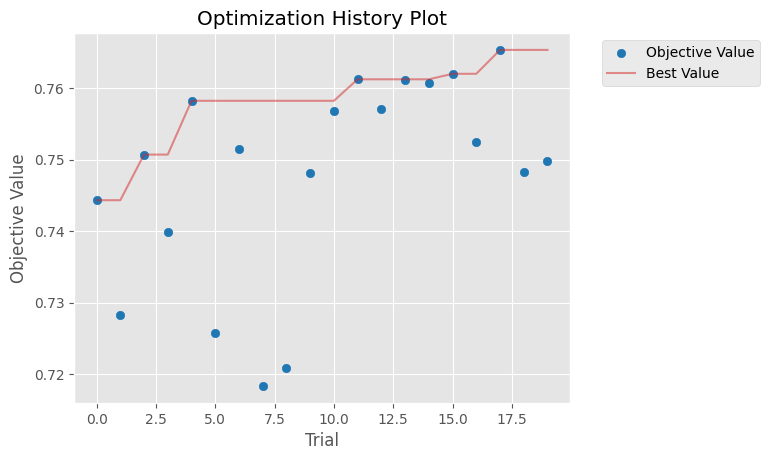

In [47]:
fig = optuna.visualization.matplotlib.plot_optimization_history(study)

C:\Users\steve\AppData\Local\Temp\ipykernel_11080\1036994904.py:1: ExperimentalWarning: plot_param_importances is experimental (supported from v2.2.0). The interface can change in the future.
  optuna.visualization.matplotlib.plot_param_importances(study)


<Axes: title={'left': 'Hyperparameter Importances'}, xlabel='Hyperparameter Importance', ylabel='Hyperparameter'>

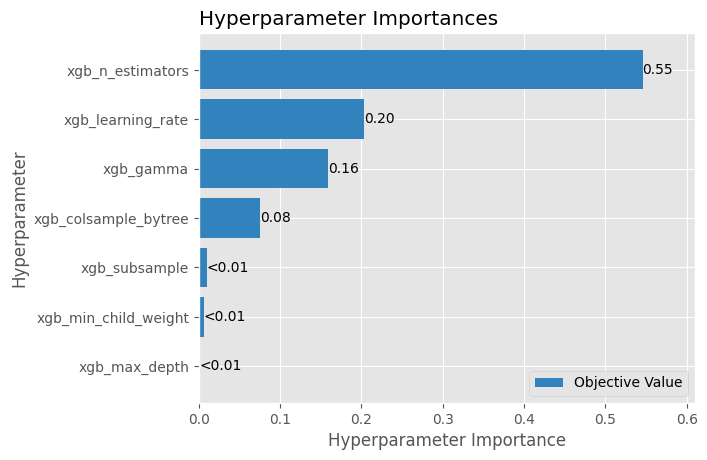

In [48]:
optuna.visualization.matplotlib.plot_param_importances(study)

C:\Users\steve\AppData\Local\Temp\ipykernel_11080\1403512554.py:1: ExperimentalWarning: plot_slice is experimental (supported from v2.2.0). The interface can change in the future.
  optuna.visualization.matplotlib.plot_slice(


array([<Axes: xlabel='xgb_colsample_bytree', ylabel='Objective Value'>,
       <Axes: xlabel='xgb_gamma'>, <Axes: xlabel='xgb_learning_rate'>,
       <Axes: xlabel='xgb_max_depth'>,
       <Axes: xlabel='xgb_min_child_weight'>,
       <Axes: xlabel='xgb_n_estimators'>, <Axes: xlabel='xgb_subsample'>],
      dtype=object)

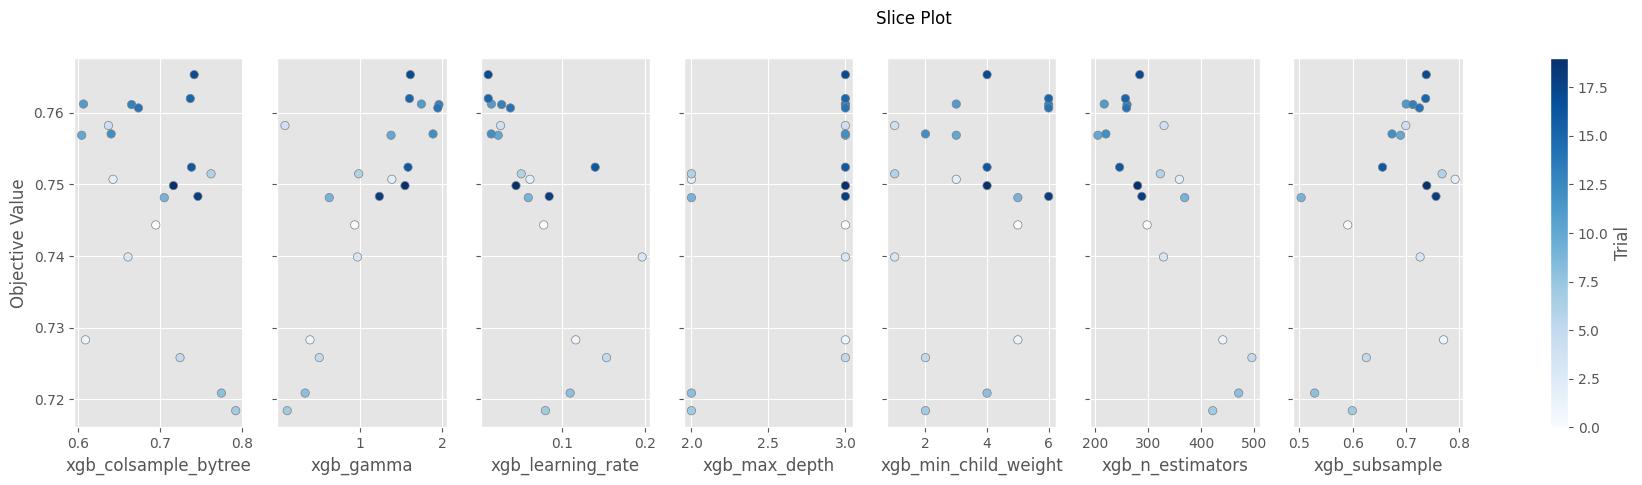

In [49]:
optuna.visualization.matplotlib.plot_slice(
    study,
    params=["xgb_n_estimators", "xgb_max_depth", "xgb_learning_rate", 
            'xgb_subsample', 'xgb_colsample_bytree', 'xgb_min_child_weight',
            'xgb_gamma'],
)

C:\Users\steve\AppData\Local\Temp\ipykernel_11080\2601326980.py:1: ExperimentalWarning: plot_edf is experimental (supported from v2.2.0). The interface can change in the future.
  optuna.visualization.matplotlib.plot_edf([study])


<Axes: title={'center': 'Empirical Distribution Function Plot'}, xlabel='Objective Value', ylabel='Cumulative Probability'>

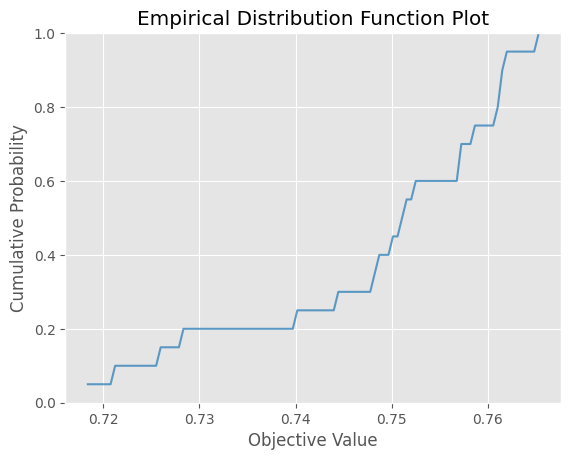

In [50]:
optuna.visualization.matplotlib.plot_edf([study])

## Classification

In [51]:
def run_model(classifier_name, sel_method, X_train, y_train):
        
        model = XGBClassifier(
                n_estimators=study.best_params["xgb_n_estimators"],
                max_depth=study.best_params["xgb_max_depth"],
                learning_rate=study.best_params["xgb_learning_rate"],
                subsample=study.best_params["xgb_subsample"],
                colsample_bytree=study.best_params["xgb_colsample_bytree"],
                min_child_weight=study.best_params["xgb_min_child_weight"],
                gamma=study.best_params["xgb_gamma"],
                objective="multi:softprob",
                num_class=len(set(y_train))
        )

        if sel_method == "Boruta":
                sel_method = "Boruta" 
        else: 
                sel_method = "Complete"
        
        skf = StratifiedKFold(n_splits=10,
                             shuffle=True,
                             random_state=42,
        )
        
        cross_val_results = cross_validate(model,
                                           X_train,
                                           y_train,
                                           cv=skf,
                                           scoring="balanced_accuracy",
                                           return_train_score=True,
        )
               
        # Calculate the metrics for training and testing
        mean_train = [round(np.mean(cross_val_results["train_score"]), 3)]
        std_train = [round(np.std(cross_val_results["train_score"]), 3)]
        mean_test = [round(np.mean(cross_val_results["test_score"]), 3)]
        std_test = [round(np.std(cross_val_results["test_score"]), 3)]
        time = round(np.mean(cross_val_results["fit_time"]), 3)
                
        cv_metrics_df = pd.DataFrame({
                "Feature Selection": sel_method,
                "Classifier": classifier_name,
                "Fit Time": time,
                "Total Features": len(X_train.columns),
                "Metric": "balanced_accuracy",
                "Mean Train": mean_train,
                "Std Train": std_train,
                "Mean Test": mean_test,
                "Std Test": std_test,
        })
        
        fit_model = model.fit(X_train, y_train)
        
        return fit_model, cv_metrics_df


In [52]:
trained_xgb_n, metrics_xgb_n = run_model("XGBoost", "Complete", X_train_missForest_t, y_train)
trained_xgb_t, metrics_xgb_t = run_model("XGBoost", "Boruta", X_train_t, y_train)

In [53]:
validation_df = pd.concat([metrics_xgb_n, metrics_xgb_t])
validation_df_report = validation_df.set_index(["Classifier", "Metric", "Feature Selection", "Fit Time", "Total Features"])
validation_df_report

Mean Train  \
Classifier Metric            Feature Selection Fit Time Total Features               
XGBoost    balanced_accuracy Complete          1.076    22                   0.857   
                             Boruta            0.622    8                    0.832   

                                                                        Std Train  \
Classifier Metric            Feature Selection Fit Time Total Features              
XGBoost    balanced_accuracy Complete          1.076    22                  0.009   
                             Boruta            0.622    8                   0.006   

                                                                        Mean Test  \
Classifier Metric            Feature Selection Fit Time Total Features              
XGBoost    balanced_accuracy Complete          1.076    22                  0.759   
                             Boruta            0.622    8                   0.765   

                                                                        Std Test  
Classifier Metric            Feature Selection Fit Time Total Features            
XGBoost    balanced_accuracy Complete          1.076    22                 0.080  
                             Boruta            0.622    8                  0.074

In [54]:
from sklearn.utils import resample

def bootstrap_ci(model, X, y, metric_fn, n_iterations, ci=0.95, use_proba=False):
    scores = []
    n = len(X)
    for _ in range(n_iterations):
        X_resampled, y_resampled = resample(X, y, n_samples=n, stratify=y)
        try:
            y_pred = model.predict_proba(X_resampled) if use_proba else model.predict(X_resampled)
            score = metric_fn(y_resampled, y_pred)
            if not np.isnan(score):
                scores.append(score)
        except Exception:
            # Skip this bootstrap sample if error occurs (e.g. missing class for roc_auc)
            continue
    if len(scores) == 0:
        return (np.nan, np.nan)
    lower = np.percentile(scores, (1 - ci) / 2 * 100)
    upper = np.percentile(scores, (1 + ci) / 2 * 100)
    std_dev = np.std(scores)
    return round(lower, 3), round(upper, 3), round(std_dev, 3)

In [55]:
from sklearn.metrics import confusion_matrix

def compute_specificity(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    total = cm.sum()
    tp = np.diag(cm)
    fp = cm.sum(axis=0) - tp
    fn = cm.sum(axis=1) - tp
    tn = total - (tp + fp + fn)
    specificity = tn / (tn + fp)
    return round(np.nanmean(specificity), 3)

In [56]:
import time

def eval_model(classifier_name, model, X_train, X_test, y_train, y_test):
        
        if isinstance(X_train, np.ndarray):
                columns = X_train.shape[1]
        else:
                columns = len(X_train.columns)        
        
        start_time = time.time()
        # Get predicted probabilities for ROC AUC
        pred_train_proba = model.predict_proba(X_train)
        pred_test_proba = model.predict_proba(X_test)
        
        # Get predicted accuracy values
        pred_train = model.predict(X_train)
        pred_test = model.predict(X_test)
        
        # Calculate metrics
        # Calculate metrics
        metrics_train = {
                "accuracy": accuracy_score(y_train, pred_train),
                "balanced_accuracy": balanced_accuracy_score(y_train, pred_train),
                "precision_macro": precision_score(y_train, pred_train, average="macro", zero_division=0),
                "recall_macro": recall_score(y_train, pred_train, average="macro", zero_division=0),
                "f1_macro": f1_score(y_train, pred_train, average="macro", zero_division=0),
                "roc_auc_macro": roc_auc_score(y_train, pred_train_proba, average="macro", multi_class="ovr"),
                "specificity_macro": compute_specificity(y_train, pred_train),
        }

        metrics_test = {
                "accuracy": accuracy_score(y_test, pred_test),
                "balanced_accuracy": balanced_accuracy_score(y_test, pred_test),
                "precision_macro": precision_score(y_test, pred_test, average="macro", zero_division=0),
                "recall_macro": recall_score(y_test, pred_test, average="macro", zero_division=0),
                "f1_macro": f1_score(y_test, pred_test, average="macro", zero_division=0),
                "roc_auc_macro": roc_auc_score(y_test, pred_test_proba, average="macro", multi_class="ovr"),
                "specificity_macro": compute_specificity(y_test, pred_test),
        }
                
        elapsed_time = time.time() - start_time
        
        # Metric functions for bootstrap CI (exclude ROC AUC here)
        metric_fns = {
                "accuracy": accuracy_score,
                "balanced_accuracy": balanced_accuracy_score,
                "precision_macro": lambda yt, yp: precision_score(yt, yp, average="macro", zero_division=0),
                "recall_macro": lambda yt, yp: recall_score(yt, yp, average="macro", zero_division=0),
                "f1_macro": lambda yt, yp: f1_score(yt, yp, average="macro", zero_division=0),
                "roc_auc_macro": lambda yt, yp: roc_auc_score(yt, yp, average="macro", multi_class="ovr"),
                "specificity_macro": lambda yt, yp: compute_specificity(yt, yp),
        }

        # Bootstrap confidence intervals
        ci_test = {
                m: bootstrap_ci(
                model, X_test, y_test, fn,
                n_iterations=1000,
                use_proba=(m == "roc_auc_macro")
                )
                for m, fn in metric_fns.items()
        }

        # Separate CI bounds and std with clear variable names
        ci_bounds = []
        std_values = []
                
        for lower, upper, std in ci_test.values():
                ci_bounds.append(f"[{round(lower, 3)}, {round(upper, 3)}]")
                std_values.append(round(std, 3)) 
                
        # Round metric values
        train_rounded = [round(score, 3) for score in metrics_train.values()]
        test_rounded = [round(score, 3) for score in metrics_test.values()] 
    
        # Create the DataFrame without additional rounding
        pred_metrics_df = pd.DataFrame({
                "Feature Selection": "Boruta",
                "Classifier": classifier_name,
                "Classification Time": round(elapsed_time, 3),
                "Total Features": columns,
                "Metric": list(metrics_train.keys()),      
                "Train data": train_rounded,
                "Test data": test_rounded,
                "95% CI": ci_bounds,
                "Std Dev": std_values,
        })
        
        return pred_metrics_df

In [57]:
results = "all"
prediction_df_report = None

if results == "all":
    
    pred_xgb_n = eval_model("XGBoost", trained_xgb_n, X_train_missForest_t, X_test_missForest_t, y_train, y_test)
    pred_xgb_t = eval_model("XGBoost", trained_xgb_t, X_train_t, X_test_t, y_train, y_test)
    
    prediction_df = pd.concat([pred_xgb_n, pred_xgb_t])
    prediction_df_report = prediction_df.set_index(["Feature Selection", "Classifier", "Classification Time", "Total Features", "Metric"])
        
elif results == "filtered":

    pred_xgb_t = eval_model("XGBoost", trained_xgb_t, X_train_t, X_test_t, y_train, y_test)
    
    prediction_df = pd.concat([pred_xgb_t])
    prediction_df_report = prediction_df.set_index(["Feature Selection", "Classifier", "Classification Time", "Total Features", "Metric"])

prediction_df_report

Train data  \
Feature Selection Classifier Classification Time Total Features Metric                          
Boruta            XGBoost    0.245               22             accuracy                0.852   
                                                                balanced_accuracy       0.854   
                                                                precision_macro         0.855   
                                                                recall_macro            0.854   
                                                                f1_macro                0.854   
                                                                roc_auc_macro           0.965   
                                                                specificity_macro       0.924   
                             0.158               8              accuracy                0.833   
                                                                balanced_accuracy       0.835   
                                                                precision_macro         0.839   
                                                                recall_macro            0.835   
                                                                f1_macro                0.836   
                                                                roc_auc_macro           0.951   
                                                                specificity_macro       0.914   

                                                                                   Test data  \
Feature Selection Classifier Classification Time Total Features Metric                         
Boruta            XGBoost    0.245               22             accuracy               0.734   
                                                                balanced_accuracy      0.734   
                                                                precision_macro        0.744   
                                                                recall_macro           0.734   
                                                                f1_macro               0.735   
                                                                roc_auc_macro          0.894   
                                                                specificity_macro      0.859   
                             0.158               8              accuracy               0.741   
                                                                balanced_accuracy      0.739   
                                                                precision_macro        0.761   
                                                                recall_macro           0.739   
                                                                f1_macro               0.745   
                                                                roc_auc_macro          0.885   
                                                                specificity_macro      0.861   

                                                                                           95% CI  \
Feature Selection Classifier Classification Time Total Features Metric                              
Boruta            XGBoost    0.245               22             accuracy           [0.671, 0.797]   
                                                                balanced_accuracy    [0.658, 0.8]   
                                                                precision_macro     [0.677, 0.81]   
                                                                recall_macro       [0.662, 0.799]   
                                                                f1_macro           [0.662, 0.805]   
                                                                roc_auc_macro      [0.859, 0.928]   
                                                                specificity_macro  [0.824, 0.894]   
                             0.158               8              accuracy           [

### Export model

In [58]:
import pickle

# Save the trained model using pickle
with open("xgboost_model.pkl", "wb") as file:
    pickle.dump(trained_xgb_t, file)

print("XGBppst model saved successfully!")

XGBppst model saved successfully!
